### Notebook to be used to perform manual focus testing using ACCS Images

In [2]:
import numpy as np
from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter as gauss_filt
from matplotlib import pyplot as plt

import SALPY_ATCamera
#import SALPY_ATSpectrograph
#import SALPY_ATArchiver

In [3]:
#ATSpectrograph = salobj.Remote(SALPY_ATSpectrograph)
ATCamera = salobj.Remote(SALPY_ATCamera)
#ATArchiver = salobj.Remote(SALPY_ATArchiver)

#### Setup the spectrograph

In [ ]:
#  bring into enable state if required
if False:
    try:
        asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_enable.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")

In [3]:
ATSpectrograph.cmd_changeFilter.set(filter=0)
try:
    asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_changeFilter.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")


filt_pos=ATSpectrograph.evt_reportedFilterPosition.get()
print(filt_pos.position)

0


In [4]:
ATSpectrograph.cmd_changeDisperser.set(disperser=1)
asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_changeDisperser.start())
disp_pos=ATSpectrograph.evt_reportedDisperserPosition.get()
print(disp_pos.position)

1


In [16]:
ATSpectrograph.cmd_moveLinearStage.set(distanceFromHome=5)
try:
    asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_moveLinearStage.start())
    lin_stage_pos=asyncio.get_event_loop().run_until_complete(ATSpectrograph.evt_reportedLinearStagePosition.next(flush=False, timeout=10))
    print(lin_stage_pos)
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")


Failed with ack.result=Failed: Change position timed out trying to move to position 5.0.


In [17]:
lin_stage_pos=asyncio.get_event_loop().run_until_complete(ATSpectrograph.evt_reportedLinearStagePosition.next(flush=False, timeout=10))
print(lin_stage_pos)

In [13]:
print(lin_stage_pos.position)

20.0


In [5]:
if True:
    try:
        ATSpectrograph.cmd_homeLinearStage.set(value=True)
        asyncio.get_event_loop().run_until_complete(ATSpectrograph.cmd_homeLinearStage.start())
        lin_stage_pos=ATSpectrograph.evt_reportedLinearStagePosition.get()
        print(lin_stage_pos.position)
    except salobj.AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")


Failed with ack.result=Failed: 'CSC' object has no attribute 'home_gs'


#### Setup the Camera

In [5]:
#  bring into enable state if required
if False:
    try:
        asyncio.get_event_loop().run_until_complete(ATCamera.cmd_enable.start())
    except AckError as ack_err:
        print(f"Failed with ack.result={ack_err.ack.result}")

In [6]:
#asyncio.get_event_loop().run_until_complete(ATCamera.cmd_start.start())

In [16]:
ATCamera.cmd_takeImages.set(expTime=1.0, shutter=1, numImages=1, imageSequenceName='FLAT')

False

In [17]:
try:
    asyncio.get_event_loop().run_until_complete(ATCamera.cmd_takeImages.start())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

In [18]:
endReadout = asyncio.get_event_loop().run_until_complete(ATCamera.evt_endReadout.next(flush=False, timeout=30))
startIntegration = asyncio.get_event_loop().run_until_complete(ATCamera.evt_startIntegration.next(flush=False, timeout=30))
print(endReadout.imageName)

AT_O_20190612_000006


In [22]:
print(endReadout.imageIndex)
print(endReadout.imagesInSequence)
print(endReadout.imageName)
print(endReadout.imageSequenceName)
print(startIntegration.timeStamp)
print(startIntegration.imageIndex)

0
1
AT_O_20190507_000003
FLAT
1557257997.173
0


In [436]:
async def take_image():
    ATCamera.cmd_takeImages.set(expTime=0)
    coro_cmd = ATCamera.cmd_takeImages.start()
    coro_evt = ATCamera.evt_endReadout.next(flush=False, timeout=30)
    
    await asyncio.gather(coro_cmd, coro_evt)

In [439]:
try:
    coro_list = asyncio.get_event_loop().run_until_complete(take_image())
except salobj.AckError as ack_err:
    print(f"Failed with ack.result={ack_err.ack.result}")

Failed with ack.result=Ack : NO Command rejected: Invalid exposure time


In [385]:
# Read in image
#dir = '/mnt/dmcs/20180823'
dir = '/mnt/data/ats/mcm/20190403/'
atcamera_fname='AT_O_20190403_000072'
#atcamera_fname=endReadout.imageName

#dir = '/mnt/dmcs/2019-03-08/'
#atcamera_fname='AT_O_20190308_000125-ats-wfs_ccd'

full_file_name=dir+atcamera_fname+'.fits'
print('Opening {}'.format(full_file_name))
hdu_list = fits.open(full_file_name)
#hdu_list.info()
im=hdu_list[12].data # for camera data

Opening /mnt/data/ats/mcm/20190403/AT_O_20190403_000072.fits


In [386]:
#print(repr(hdu_list[0].header))

In [387]:
if False:
    im_sub=im-np.median(im)
    plt.imshow(im_sub)
    hdu_list.close()

In [388]:
# Find star by convolution with gaussian, then grab the max
tmp=gauss_filt(im,[5,5],mode='constant',cval=0)
print(np.max(tmp))
value=None
ind=np.argmax(tmp)
ind2d = np.unravel_index(ind,tmp.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(10)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < 2047 else 2047
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < 512 else 512
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(tmp[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,tmp[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

13653
centroid at y,x: 1814 352
subimage being made from ymin,ymax,xmin,xmax:1804 1824 342 362
new centroid at y,x: 10 10


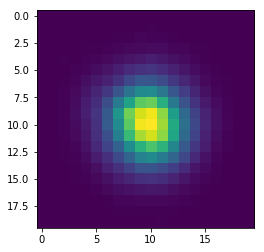

In [389]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
hdu_list.close()

10
10


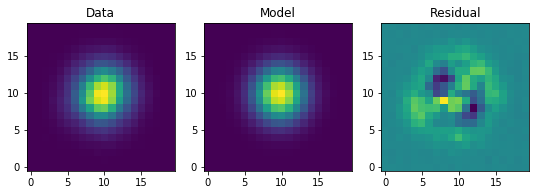

In [390]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [391]:
print(atcamera_fname)
print(p)

AT_O_20190403_000072
Model: Gaussian2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Parameters:
      amplitude       x_mean        y_mean       x_stddev      y_stddev   theta
    ------------- ------------- ------------- ------------- ------------- -----
    18797.0589176 9.72130537745 9.92428398597 2.34364092035 2.45635093767   0.0


#### file, focus pos [in], amplitude, x_mean, y_mean, x_stddev, y_stddev, theta [fixed] 
AT-O-20180926-00021, 0.562, 15870.7070175, 98.2141308141, 56.3088127495, 5.15586715284, 4.88307143492,   0.0 <br>
15 um pihole <br>
AT_O_20190307_000019, 85.21, 108144.327522 49.7379776615 49.4345579468 14.8616659362 15.465663748   0.0 <br>
AT_O_20190307_000020, 84.49,44967.8593151 48.9497402539 50.2846418748 15.3738814453 17.9581401095   0.0 <br>
AT_O_20190307_000022, 86.52, 93058.4239815 49.5835058745 49.9918142155 4.81553867288 5.13646717767   0.0 <br>
changed boxsize to 30 <br>
AT_O_20190307_000023, 86.74, 329693.886659 30.1836323063 29.9334425162 3.01478897239 2.8575321053   0.0 <br>
AT_O_20190307_000024, 87.12, 295742.555002 30.4913217454 30.3317351434 3.11510954329 3.25791024973   0.0 <br>
AT_O_20190307_000025, 86.19, 56511.1359113 29.7477946879 29.6581194245 6.10740920894 6.82905777784   0.0 <br>
AT_O_20190307_000026, 86.51, 199852.873849 29.5918056313 29.7152382087 3.35941499774 3.51909832344   0.0 <br>
<br>
AT_O_20190403_000043, 86.84, 47193.2995262 10.1770464631 9.58557396978 2.42186350619 2.33253803551   0.0 <br>
AT_O_20190403_000058, 87.0, 60780.3988054 10.3854763745 9.81653223519 2.09498458905 2.18381847915   0.0 <br>
AT_O_20190403_000059, 87.25, 10496.9450352 10.3321166429 10.3178915386 3.29602335958 3.18432359685   0.0 <br>
AT_O_20190403_000060, 87.17, 19601.6079323 10.2477154384 10.0856153463 3.14769062096 3.18421825848   0.0 <br>
AT_O_20190403_000061, 86.87, 54387.2443399 10.0928949949 10.2432991149 2.13034331442 2.11887896719   0.0 <br>
AT_O_20190403_000062, 87.00, 42152.0302352 9.81355306651 10.036868197 2.41075614552 2.43991643928   0.0 <br>
?64 86.77, 51691.254321 10.0069253537 10.3383953884 2.30251536729 2.10742325553   0.0 <br>
?65, 86.84, 54227.2571204 9.72396800542 9.6165816677 2.22070291525 2.12443501117   0.0<br>
AT_O_20190403_000066, 86.86,  31539.8881478 10.1121943524 9.91162028618 2.24264123635 2.04075141788   0.0<br> 

AT_O_20190403_000067, 86.92, 29294.7502985 9.7799875292 9.70992331211 2.1707047694 2.2314911659   0.0  @ 632 nm <br>
AT_O_20190403_000068, 86.92, 30692.693266 10.4100367967 10.2439172009 2.39368673584 2.42869283387   0.0 @ 532 nm <br>
AT_O_20190403_000069, 86.92, 49439.235903 9.61762946836 9.78623937611 2.11873799437 2.25860610821   0.0 @ 732 nm <br>
AT_O_20190403_000070, 86.92, 22329.9098714 10.1640712417 10.2179073827 3.16090407303 2.92798810201   0.0  @ 832 <br> # CHECK PEAK!
AT_O_20190403_000071, 86.92, 14223.152027 10.1563920627 9.90674668135 2.09985503759 2.20372016625   0.0@ 939nm <br>
AT_O_20190403_000072, 86.92, 18797.0589176 9.72130537745 9.92428398597 2.34364092035 2.45635093767   0.0 @ 432 nm <br>


In [381]:
# magnification of the system is ~3.2, so 15um pinhole becomes 48um, which is a width of ~5 pixels
# but it'll be resolved... 5 pixel wide top hat convolved with the diffraction limit (for a perfect system)
# diffraction limit is 3.1 pixels FWHM. 
#The zemax model shows that we're not going to (easily) resolve the pinhole, so it'll basically
# be a Gaussian. Moreover, we're definitely not using a perfect optical system so there's
# aberrations that will certainly reduce our resolution. I expect to measure a Gaussian profile.

In [239]:
632e-9*400/24. * 1e6

10.533333333333335

In [346]:
632/120

5.266666666666667

In [288]:
# Make an encircled energy plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [289]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [290]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

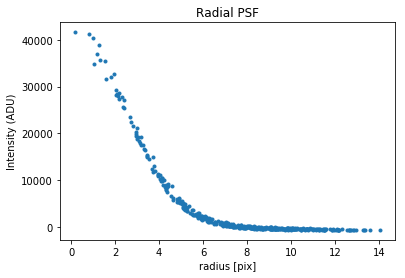

In [291]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()